In [193]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# Text preprocessing

In [194]:
mickiewicz_pan_tadeusz = open('mickiewicz/pan_tadeusz.txt', 'r').read()
mickiewicz_dziady = open('mickiewicz/dziady.txt', 'r').read()

mickiewicz = mickiewicz_pan_tadeusz + mickiewicz_dziady

len(mickiewicz)

466662

In [195]:
slowacki_kordian = open('slowacki/kordian.txt', 'r').read()
len(slowacki_kordian)
słowacki = slowacki_kordian

In [196]:
tuwim_matka = open('tuwim/matka.txt', 'r').read()
tuwim_lokomotywa = open('tuwim/lokomotywa.txt', 'r').read()
tuwim = tuwim_matka + tuwim_lokomotywa
len(tuwim)

2940

In [197]:
bronte = open('bronte/jane_eyre_fragment.txt', 'r').read()
len(bronte)

112892

In [198]:
# !pip install nltk

In [199]:
# !pip install inflect


In [200]:
from helpers import remove_non_ascii, to_lowercase, remove_punctuation, replace_numbers, remove_stopwords, stem_words, lemmatize_verbs, normalize

In [201]:
import nltk
sent = nltk.data.load(
    'tokenizers/punkt/polish.pickle'
)

def remove_end_lines(text):
    data = []
    for item in text:
        data.append(item.replace('\n', ' '))
    return data

def preprocess(text):
    words = sent.tokenize(text)
    words = normalize(words)
    words = remove_end_lines(words)
    print(words[:10])
    return words

In [202]:
mickiewicz_data = preprocess(mickiewicz)
tuwim_data = preprocess(tuwim)
slowacki_data = preprocess(słowacki)
bronte_data = preprocess(bronte)
print(len(mickiewicz_data))
print(len(tuwim_data))
print(len(slowacki_data))
print(len(bronte_data))


['adam mickiewicz  pan tadeusz czyli ostatni zajazd na litwie   ksiega pierwsza    gospodarstwo  powrot panicza  spotkanie sie pierwsze w pokoiku drugie u stou  wazna sedziego nauka o grzecznosci  podkomorzego uwagi polityczne nad modami  poczatek sporu o kusego i sokoa  zale wojskiego  ostatni wozny trybunau  rzut oka na owczesny stan polityczny litwy i europy      litwo', 'ojczyzno moja', 'ty jestes jak zdrowie ile cie trzeba cenic ten tylko sie dowie kto cie straci', 'dzis pieknosc twa w caej ozdobie widze i opisuje bo tesknie po tobie', 'panno swieta co jasnej bronisz czestochowy i w ostrej swiecisz bramie', 'ty co grod zamkowy nowogrodzki ochraniasz z jego wiernym ludem', 'jak mnie dziecko do zdrowia powrocias cudem gdy od paczacej matki pod twoja opieke ofiarowany martwa podniosem powieke i zaraz mogem pieszo do twych swiatyn progu isc za wrocone zycie podziekowac bogu tak nas powrocisz cudem na ojczyzny ono', 'tymczasem przenos moja dusze uteskniona do tych pagorkow lesnych do t

In [203]:
import pandas as pd

mickiewicz_dict = {
    "text" : mickiewicz_data,
    "label": np.zeros(len(mickiewicz_data), dtype=np.int16)
}

tuwim_dict = {
    "text" : tuwim_data,
    "label": np.ones(len(tuwim_data), dtype=np.int16)
}

slowacki_dict = {
    "text" : slowacki_data,
    "label": np.full(len(slowacki_data), 2, dtype=np.int16)
}

bronte_dict = {
    "text" : bronte_data,
    "label": np.full(len(bronte_data), 3, dtype=np.int16)
}

print(mickiewicz_dict["label"])
mickiewicz_df = pd.DataFrame.from_dict(mickiewicz_dict)
tuwim_df = pd.DataFrame.from_dict(tuwim_dict)
slowacki_df = pd.DataFrame.from_dict(slowacki_dict)
bronte_df = pd.DataFrame.from_dict(bronte_dict)
print(mickiewicz_df.head())
print(tuwim_df.head())


[0 0 0 ... 0 0 0]
                                                text  label
0  adam mickiewicz  pan tadeusz czyli ostatni zaj...      0
1                                      ojczyzno moja      0
2  ty jestes jak zdrowie ile cie trzeba cenic ten...      0
3  dzis pieknosc twa w caej ozdobie widze i opisu...      0
4  panno swieta co jasnej bronisz czestochowy i w...      0
                                                text  label
0  julian tuwim  matka  i  jest na odzkim cmentar...      1
1  grob mojej matki polki mojej matki zydowki zna...      1
2  gaz mogie przywali a na gazie pobladym troche ...      1
3  a gdy wietrzyk soneczny igra z nimi zociscie w...      1
4  ii  zastrzeli ja faszysta kiedy myslaa o mnie ...      1


In [204]:
df = pd.concat([mickiewicz_df, slowacki_df, bronte_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,label
0,jezeli oni mnie nie kochali to i ja rowniez ic...,3
1,jej zjawienie sie nage jej wzrost i uroda jej ...,0
2,szatan taki sie teraz zrobi czuy i pobozny ja...,2
3,ale hrabia do niej chcia koniecznie cos mowic ...,0
4,obok lamus spichrz gumno obora i stajnie wszys...,0


In [205]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, min_df= 3, max_df=0.6)
X = vectorizer.fit_transform(df["text"]).toarray()
X[2]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [206]:
y = df["label"].values
y
len(y)

6611

In [207]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape


(5288, 1000)

In [208]:
import torch
import torch.nn as nn

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()


In [209]:
X_train.shape, X_train.shape

(torch.Size([5288, 1000]), torch.Size([5288, 1000]))

In [210]:
input_size = 1000
output_size = 4
hidden_size = 500

In [211]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, X):
        out = self.fc1(X)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.softmax(out)
        return out

In [212]:
def train_model(model, X_train, y_train, epochs, lr):
    model.train()
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_data = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(X_train)
        loss = criterion(out, y_train)
        loss_data.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch} loss is {loss}")

    plt.figure(figsize=(8, 4))
    plt.plot(loss_data, label="Training loss")
    plt.legend()
    return model

def test_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        _, predicted = torch.max(output, 1)
        correct = (predicted == y_test).sum().item()

        print(f"Accuracy: {correct/len(y_test)}")

        print(X_test[:10])
        print(y_test[:10])
        print(predicted[:10])
        print(f"Accuracy: {correct/len(y_test)}")


Epoch 0 loss is 1.3974733352661133
Epoch 10 loss is 1.37505304813385
Epoch 20 loss is 1.349985122680664
Epoch 30 loss is 1.3174060583114624
Epoch 40 loss is 1.2736968994140625
Epoch 50 loss is 1.2176949977874756
Epoch 60 loss is 1.1505749225616455
Epoch 70 loss is 1.0810134410858154
Epoch 80 loss is 1.0229026079177856
Epoch 90 loss is 0.9796628355979919
Epoch 100 loss is 0.9438946843147278
Epoch 110 loss is 0.9119485020637512
Epoch 120 loss is 0.8822673559188843
Epoch 130 loss is 0.8529866933822632
Epoch 140 loss is 0.8229208588600159
Epoch 150 loss is 0.7910920977592468
Epoch 160 loss is 0.7567458152770996
Epoch 170 loss is 0.7193754315376282
Epoch 180 loss is 0.6793814897537231
Epoch 190 loss is 0.6373729705810547
Epoch 200 loss is 0.5946075320243835
Epoch 210 loss is 0.5527302622795105
Epoch 220 loss is 0.5130658149719238
Epoch 230 loss is 0.47693541646003723
Epoch 240 loss is 0.4450262188911438
Epoch 250 loss is 0.4174070656299591
Epoch 260 loss is 0.3936310112476349
Epoch 270 loss

<Figure size 1000x500 with 0 Axes>

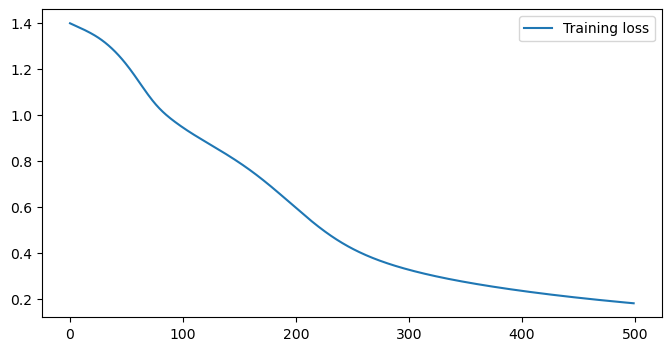

<Figure size 1000x500 with 0 Axes>

In [213]:
epochs = 500
learning_rate = 0.0001

model = Net()

model = train_model(model, X_train, y_train, epochs, learning_rate)
test_model(model, X_test, y_test)

plt.figure(figsize=(10, 5))


In [214]:
#test

In [215]:
# print(tuwim_data)
# tuwim_data_set = set(tuwim_data)

In [216]:
# import pandas as pd
# import os
# class CustomImageDataset():
#     def __init__(self, words, labels):
#         self.labels = labels
#         self.words = words

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#         # image = read_image(img_path)
#         label = self.img_labels.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label

In [217]:
# def word_pairs(words):
#     pairs = []
#     for i in range(len(words) - 1):
#          pairs.append((words[i], words[i + 1]))
#     return pairs

# def convert_pairs_to_vectors(pairs, word2idx):
#     x,y=[],[]
#     for pair in pairs:
#         x.append(word2idx[pair[0]])
#         y.append(word2idx[pair[1]])
#     return x,y

# def create_word2idx(words):
#     word2idx = {word: i for i, word in enumerate(set(words))}
#     idx2word = {i: word for word, i in word2idx.items()}
#     return word2idx, idx2word

# word2idx, idx2word = create_word2idx(tuwim_data)
# word_pairs(tuwim_data)
# vectors = convert_pairs_to_vectors(word_pairs(tuwim_data), word2idx)

In [218]:
# embeds = nn.Embedding(len(tuwim_data), 2)  # 2 words in vocab, 5 dimensional embeddings
# lookup_tensor = torch.tensor(vectors, dtype=torch.long)
# embeded_tuwim = embeds(lookup_tensor)[0].detach().numpy()
# # print(embeded_tuwim)

# import matplotlib.pyplot as plt
# for i, label in enumerate(set(tuwim_data)):
#     # print(embeded_tuwim[i])
#     x, y = embeded_tuwim[i]
#     plt.scatter(x, y)
#     plt.text(x, y, label)